In [ ]:
"""
see how well the density and reconstruction loss are related for different token counts
"""

In [1]:
import json
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import math
from torch.utils.data import DataLoader, Dataset
sys.path.append(os.path.abspath(".."))   # one level up from notebook/
from data.utils.dataloaders import clean_ReconstructionDataset_Heuristic

/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# read reconstruction loss json file 
with open('/BS/data_mani_compress/work/thesis/thesis/data/datasets/imagenet_reconstruction_losses/val_categorized/all_losses.json', 'r') as f:
    reconst_losses = json.load(f)

In [67]:
class clean_ReconstructionDataset_Heuristic(Dataset):
    """
    this is different from ReconstructionDataset_token_based in the sense that this also has the edge information.
    Optionally, it can include additional per-image scalar features such as LID and local density.
    """
    def __init__(self, reconstruction_data, edge_ratio_information=None,
                 lid_information=None, local_density_information=None,
                 lpips_variance_information=None,
                 dino_dist_information=None,
                 error_key: list[str] = ["vgg_error"]):
        """
        Args:
            reconstruction_data (list): List of dicts containing reconstruction metrics.
                (img_id, k_value, mse_error, vgg_error, ...).
            edge_ratio_information (list|dict|None): Per-image edge ratio values.
            lid_information (list|dict|None): Per-image LID values.
            local_density_information (list|dict|None): Per-image local density values.
            error_key (str): Name of the error field in reconstruction_data to expose in samples.
        """
        self.reconstruction_data = reconstruction_data
        self.edge_ratio_information = edge_ratio_information
        self.lid_information = lid_information
        self.local_density_information = local_density_information
        self.lpips_variance_information = lpips_variance_information
        self.dino_dist_information = dino_dist_information

        # Apply optional filtering on the provided error field
        self.num_original = len(reconstruction_data)
        self.reconstruction_data = reconstruction_data
        self.error_key = error_key

    def __len__(self):
        return len(self.reconstruction_data)

    def __getitem__(self, idx):
        """
        Returns a dict with:
          - error value under `self.error_key`
          - k_value (int)
          - optionally: edge_ratio, lid, local_density if the corresponding info was provided
          - image_id (int) for traceability
        """
        data_point = self.reconstruction_data[idx]
        k_value = data_point["k_value"]
        err_vals = {key: data_point[key] for key in self.error_key}
        image_id = data_point["image_id"]

        out = {
            **err_vals,
            "k_value": k_value,
            "image_id": image_id,
        }
        if self.edge_ratio_information is not None:
            out["edge_ratio"] = self.edge_ratio_information[image_id]
        if self.lid_information is not None:
            out["lid"] = self.lid_information[k_value][image_id]
        if self.local_density_information is not None:
            out["local_density"] = self.local_density_information[k_value][image_id]
        if self.lpips_variance_information is not None:
            out["lpips_variance"] = self.lpips_variance_information[k_value][image_id]
        if self.dino_dist_information is not None:
            out["dino_dist"] = self.dino_dist_information[image_id]
        return out

In [30]:
# load densities
main_folder = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/density_imagenet/subset_val/list_version/val_density_div_list_reconst_"

density_dict_1 = {}
k_values = [1,2,4,8,16,32,64,128,256]
for k in k_values:
    with open((main_folder + f"{k}/token_count/0_0000_0200.json"), 'r') as f:
        current_densities = json.load(f)
    density_dict_1[k]=current_densities

print(density_dict_1.keys(), len(density_dict_1[1]), len(density_dict_1[2]), len(density_dict_1[4]), len(density_dict_1[8]), len(density_dict_1[16]), len(density_dict_1[32]), len(density_dict_1[64]), len(density_dict_1[128]), len(density_dict_1[256]))

dict_keys([1, 2, 4, 8, 16, 32, 64, 128, 256]) 4000 4000 4000 4000 4000 4000 4000 4000 4000


In [68]:
# load densities
main_folder = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/density_imagenet/val"
density_dict_2 = {}
k_values = [1,2,4,8,16,32,64,128,256]
for k in k_values:
    with open((main_folder + f"/reconst_{k}_combined_token_count256.json"), 'r') as f:
        current_densities = json.load(f)
    density_dict_2[k]=current_densities

print(density_dict_2.keys(), len(density_dict_2[1]), len(density_dict_2[2]), len(density_dict_2[4]), len(density_dict_2[8]), len(density_dict_2[16]), len(density_dict_2[32]), len(density_dict_2[64]), len(density_dict_2[128]), len(density_dict_2[256]))

dict_keys([1, 2, 4, 8, 16, 32, 64, 128, 256]) 50000 50000 50000 50000 50000 50000 50000 50000 50000


In [40]:
# print(density_dict_1[1][0][0], "\n", density_dict_2[1][0][0])
# for i in range(50):
#     print(density_dict_1[1][0][0][i] - density_dict_2[1][0][0][i])
# print("\n", len(density_dict_1[1]), len(density_dict_2[1]))

In [36]:
density_dict_temp = {}
for key, value in density_dict.items():
    density_dict_temp[key] = value[:4000]

In [8]:
print((density_dict_2[1][0][0]))

[3768.071533203125, 3198.86669921875, 1486.958740234375, 999.1115112304688, 782.0323486328125, 657.293212890625, 596.060302734375, 557.2980346679688, 530.5676879882812, 516.591796875, 503.140380859375, 494.56298828125, 481.8648986816406, 478.2178649902344, 465.64459228515625, 456.2784423828125, 458.3029479980469, 452.8679504394531, 449.0967102050781, 444.9046630859375, 442.3697509765625, 439.00445556640625, 441.5753479003906, 431.31854248046875, 423.44171142578125, 422.0208435058594, 425.62725830078125, 422.17230224609375, 411.2027282714844, 409.1151123046875, 407.2890625, 403.1412353515625, 401.7475280761719, 397.8288879394531, 390.7752990722656, 390.4644470214844, 383.40240478515625, 382.2403869628906, 377.4404296875, 371.64739990234375, 367.85955810546875, 365.3343811035156, 357.3035888671875, 354.1623229980469, 351.7041015625, 347.8938293457031, 339.99755859375, 333.7213134765625, 331.3485107421875, 330.2225646972656]


In [77]:
k_values = [1, 2, 4, 8, 16, 32, 64, 128, 256]

corrs = []

#for j in range(50):
corr = []
for k in k_values:
    density = density_dict_2[k]

    max_density_index = len(density)  # upper bound (exclusive)
    # Filter reconstruction entries to those that have a density available
    filtered_reconst_losses = [
        rec for rec in reconst_losses
        if 'image_id' in rec and 0 <= int(rec['image_id']) and int(rec['image_id']) < 50000
    ]

    processed_density_dict = {}
    for idx, (key, value) in enumerate(density_dict_2.items()):
        processed_density_dict[key] = [sum(v[0][:]) + v[1] for v in value]
    #print(processed_density_dict[k][0:10])
    ds = clean_ReconstructionDataset_Heuristic(
        reconstruction_data=filtered_reconst_losses,  # or your processed list of dicts
        local_density_information=processed_density_dict, # [l[0] for l in density]
        error_key=["LPIPS"],
    )
    
    densities    = []
    losses_lpips = []
    for data_point in ds:
        if data_point['k_value'] == k:
            densities.append(data_point['local_density'])
            losses_lpips.append(data_point['LPIPS'])
    corr1 = np.corrcoef(densities, losses_lpips)[0, 1]
    corr.append(corr1)
    #corrs.append(corr)

In [80]:
print(corr)

[-0.14397039948746418, -0.2882659602457211, -0.49340519093508184, -0.5220409189234936, -0.5752670413786888, -0.6278788872779131, -0.6826422863452574, -0.734513795922352, -0.7738428934654322]


In [76]:
print(corr)

[-0.13358900170406565, -0.2720600926951114, -0.49243052696276196, -0.5303229700563685, -0.5897781605554819, -0.6481331268613768, -0.7066472093606384, -0.7630852127277316, -0.8053398732550465]


In [74]:
print("for last")
for idx, k in enumerate(k_values):
    best_j = min(range(50), key=lambda j: corrs[j][idx])
    best_corr = corrs[best_j][idx]
    print(f"Best j for k={k} is {best_j} with correlation {best_corr:.4f}")

print(corrs[0][8])

for last
Best j for k=1 is 0 with correlation -0.1336
Best j for k=2 is 0 with correlation -0.2721
Best j for k=4 is 0 with correlation -0.4924
Best j for k=8 is 0 with correlation -0.5303
Best j for k=16 is 0 with correlation -0.5898
Best j for k=32 is 0 with correlation -0.6481
Best j for k=64 is 0 with correlation -0.7066
Best j for k=128 is 0 with correlation -0.7631
Best j for k=256 is 4 with correlation -0.8167
-0.8053398732550465


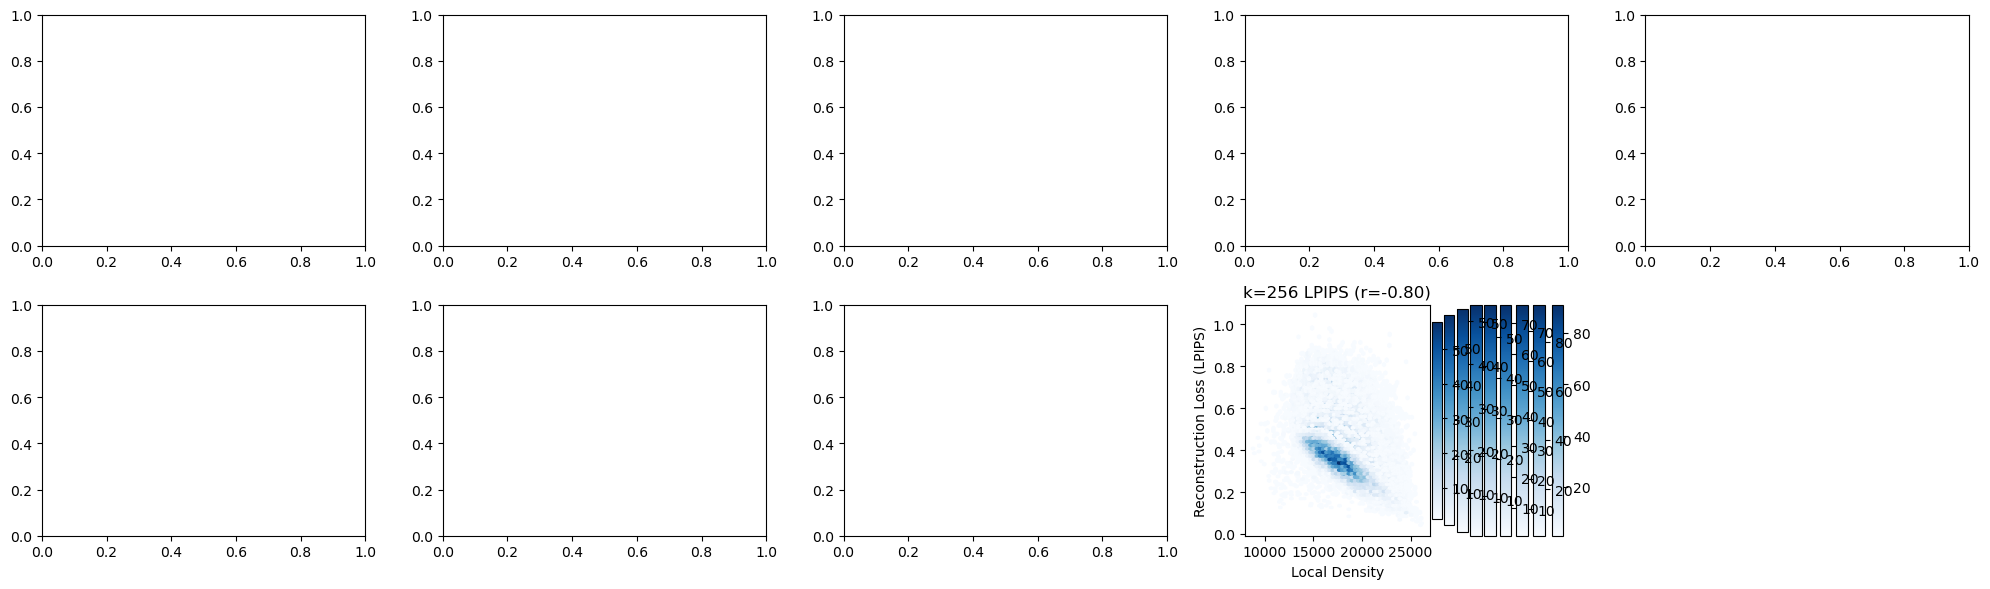

In [18]:
k_values = [1, 2, 4, 8, 16, 32, 64, 128, 256]
ncols   = 5
nrows   = int(math.ceil(len(k_values) / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3), squeeze=False)
axes_flat = axes.flatten()

corr = []

for idx, k in enumerate(k_values):
    density = density_dict_2[k]

    max_density_index = len(density)  # upper bound (exclusive)

    # Filter reconstruction entries to those that have a density available
    filtered_reconst_losses = [
        rec for rec in reconst_losses
        if 'image_id' in rec and isinstance(rec['image_id'], (int, str))
        and int(rec['image_id']) < max_density_index
    ]

    # it should be a list of densities for each data point
    processed_density_dict = {}
    for idx, (key, value) in enumerate(density_dict_2.items()):
        processed_density_dict[key] = [sum(v[0][j:]) for v in value]
    ds = clean_ReconstructionDataset_Heuristic(
        reconstruction_data=filtered_reconst_losses,  # or your processed list of dicts
        local_density_information=processed_density_dict, # [l[0] for l in density]
        error_key=["LPIPS"],
    )
    ax = axes_flat[idx]
    densities    = []
    losses_lpips = []
    for data_point in ds:
        if data_point['k_value'] == k:
            densities.append(data_point['local_density'])
            losses_lpips.append(data_point['LPIPS'])

    # First hexbin: LPIPS vs density
    hb1 = ax.hexbin(densities, losses_lpips, gridsize=50, cmap='Blues', mincnt=1)
    if len(densities) > 1:
        corr1 = np.corrcoef(densities, losses_lpips)[0, 1]
    else:
        corr1 = float('nan')
    ax.set_title(f"k={k} LPIPS (r={corr1:.2f})")
    ax.set_xlabel('Local Density')
    ax.set_ylabel('Reconstruction Loss (LPIPS)')

    corr.append(corr1)

    # Optionally add a colorbar for the first hexbin
    fig.colorbar(hb1, ax=ax, orientation='vertical', pad=0.01, fraction=0.05)

# Hide unused subplots (if grid larger than number of k_values)
for j in range(len(k_values), nrows * ncols):
    fig.delaxes(axes_flat[j])

plt.tight_layout()
plt.show()

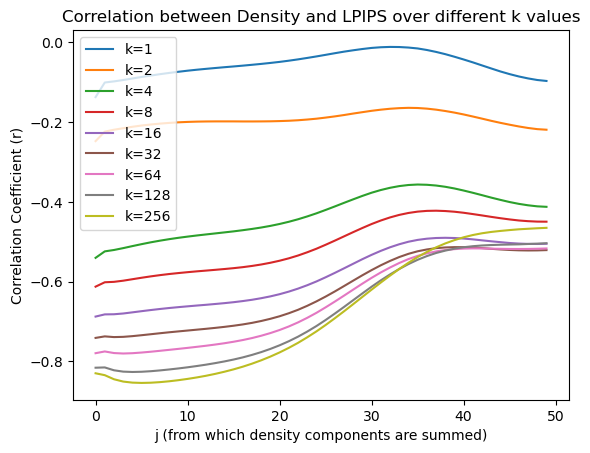

In [ ]:
# for each k, plot correlation over j
for idx, k in enumerate(k_values):
    corr_k = [corrs[j][idx] for j in range(50)]
    plt.plot(range(50), corr_k, label=f'k={k}')
    # label=f'k={k}'
plt.legend()
plt.title("Correlation between Density and LPIPS over different k values")
plt.xlabel("j (from which density components are summed)")
plt.ylabel("Correlation Coefficient (r)")
plt.show()

['-0.10', '-0.22', '-0.41', '-0.45', '-0.50', '-0.52', '-0.52', '-0.50', '-0.47']


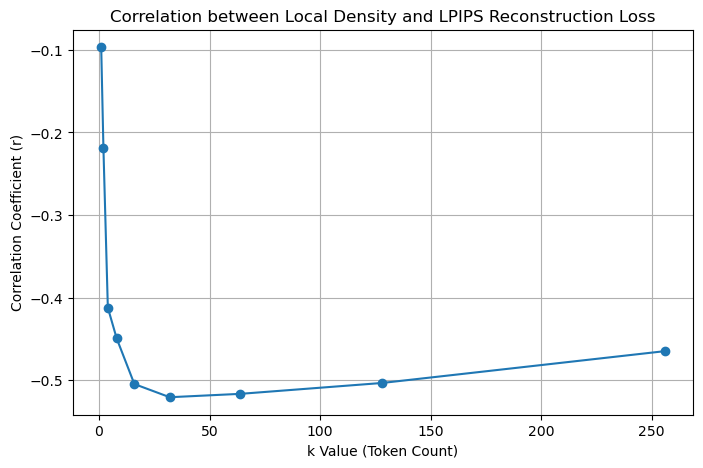

In [ ]:
print([f"{i:.2f}" for i in corr])
# plot correlation vs k_values
plt.figure(figsize=(8, 5))
plt.plot(k_values, corr, marker='o')
#plt.xscale('log', base=2)
plt.xlabel('k Value (Token Count)')
plt.ylabel('Correlation Coefficient (r)')
plt.title('Correlation between Local Density and LPIPS Reconstruction Loss')
plt.grid(True)
plt.show()